In [1]:
#This file is an attempt at linear regression in this project. 
#The linear regression classifier built using the code learned in class has a low final accuracy rate (74.32%).
# Import necessary libraries for data manipulation, visualization, and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
Data = pd.read_csv('./data/apple_quality.csv')

In [2]:
# Check for missing values in each column
Data.isnull().sum()
# Check for duplicate rows in the dataset
Data.duplicated().sum()
# Drop duplicate rows if any exist
Data.dropna(inplace = True)
# Verify that there are no remaining missing values after cleaning
Data.isnull().sum()
# Convert the 'Acidity' column to float type for consistency
Data['Acidity'] = Data['Acidity'].astype(float)
# Map the 'Quality' column values to binary: 'good' to 1 and 'bad' to 0
Data['Quality'] = Data['Quality'].map({'good':1, 'bad':0})
# Drop the column 'A_id' as it may not be relevant for analysis
Data.drop(columns=['A_id'], inplace=True)

In [3]:
# Define bounds for outliers using the interquartile range (IQR) method
filter_data=Data.iloc[:,[0,1,2,3,4,5,6]]
# Identify and remove outliers from the dataset
for column in filter_data.columns:
    Q1 = filter_data[column].quantile(0.25)
    Q3 = filter_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    Data[column] = filter_data[(filter_data[column] >= lower_bound) & (filter_data[column] <= upper_bound)][column]

In [4]:
# Check for any remaining missing values in the dataset after outlier removal
Data.isnull().sum()
# Drop any remaining missing values in the dataset
Data.dropna(inplace= True)

In [5]:
# Drop the 'Quality' column as it will be used as the target variable
X = Data.drop("Quality", axis = 1)
y = Data["Quality"]

In [6]:
# Splitting the dataset into training and testing sets
# 70% of the data will be used for training and 30% for testing
# random_state=0 ensures reproducibility of the split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [7]:
# Standardizing the features by removing the mean and scaling to unit variance
# This improves the performance of some machine learning algorithmsfrom sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [22]:
import numpy as np

# 1. 定义 Sigmoid 函数
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
    z (ndarray): A scalar, numpy array of any size.

    Returns:
    g (ndarray): sigmoid(z), with the same shape as z
    """
    # 计算 sigmoid 值
    g = 1 / (1 + np.exp(-z))
    return g

# 2. 定义前向传播函数
def forward(X, weights, bias):
    # 计算线性组合 z
    z = np.dot(X, weights) + bias
    # 通过 sigmoid 函数得到概率值
    y_pred = sigmoid(z)
    return y_pred

# 3. 定义损失函数（对数损失 / 交叉熵损失）
def compute_cost(X, y, w, b, lambda_=1):
    """
    Computes the cost over all examples

    Args:
    X (ndarray): Shape (m, n), data, m examples by n features
    y (ndarray): Shape (m,), target values
    w (ndarray): Shape (n,), values of parameters of the model
    b (float): Bias parameter of the model
    lambda_ (float): Regularization parameter (not used here, placeholder)

    Returns:
    total_cost (float): The average cost
    """
    m, n = X.shape  # m 是样本数量

    # 初始化总损失
    loss_sum = 0

    # 遍历每个样本，计算损失并累加
    for i in range(m):
        # 计算线性组合
        z = np.dot(X[i], w) + b
        # 计算预测值（使用 sigmoid 函数）
        y_pred = sigmoid(z)
        # 计算单个样本的损失（交叉熵损失）
        loss = - (y[i] * np.log(y_pred) + (1 - y[i]) * np.log(1 - y_pred))
        # 累加损失
        loss_sum += loss

    # 计算平均损失
    total_cost = loss_sum / m
    return total_cost

# 4. 定义梯度下降更新函数
def compute_gradient(X, y, w, b, lambda_=None):
    """
    Computes the gradient for logistic regression parameters

    Args:
    X (ndarray): Shape (m, n), data, m examples by n features
    y (ndarray): Shape (m,), target values
    w (ndarray): Shape (n,), values of parameters of the model
    b (float): Bias parameter of the model
    lambda_ (float): Regularization parameter (not used here, placeholder)

    Returns:
    dj_db (float): The gradient of the cost with respect to b
    dj_dw (ndarray): The gradient of the cost with respect to w
    """
    m, n = X.shape  # m 是样本数量，n 是特征数量
    
    # 初始化梯度
    dj_dw = np.zeros(w.shape)  # 权重的梯度
    dj_db = 0  # 偏置的梯度

    # 遍历每个样本，计算梯度
    for i in range(m):
        # 计算 f_wb，也就是预测值
        z = np.dot(X[i], w) + b
        f_wb = sigmoid(z)  # 使用 sigmoid 函数

        # 计算误差（预测值 - 实际值）
        error = f_wb - y[i]

        # 计算偏置的梯度并累加
        dj_db += error

        # 计算每个权重的梯度并累加
        for j in range(n):
            dj_dw[j] += error * X[i, j]

    # 计算平均梯度
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

# 5. 定义逻辑回归训练函数
def train_logistic_regression(X, y, learning_rate=0.01, epochs=1000):
    # 初始化权重和偏置
    weights = np.zeros(X.shape[1])
    bias = 0
    losses = []

    for epoch in range(epochs):
        # 前向传播并计算损失
        loss = compute_cost(X, y, weights, bias)
        losses.append(loss)
        
        # 梯度下降更新
        dj_db, dj_dw = compute_gradient(X, y, weights, bias)
        weights -= learning_rate * dj_dw
        bias -= learning_rate * dj_db

        # 每 100 次迭代打印一次损失
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return weights, bias, losses

# 6. 定义预测函数
def predict(X, weights, bias, threshold=0.5):
    # 使用前向传播得到预测概率
    y_pred = forward(X, weights, bias)
    # 将概率转化为二元分类
    y_pred_class = (y_pred >= threshold).astype(int)
    return y_pred_class


In [15]:
# Display the first few rows after dropping unnecessary columns
Data.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1
5,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,0


Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.6433
Epoch 200, Loss: 0.6127
Epoch 300, Loss: 0.5926
Epoch 400, Loss: 0.5785
Epoch 500, Loss: 0.5682
Epoch 600, Loss: 0.5604
Epoch 700, Loss: 0.5542
Epoch 800, Loss: 0.5493
Epoch 900, Loss: 0.5453
Epoch 1000, Loss: 0.5420
Epoch 1100, Loss: 0.5392
Epoch 1200, Loss: 0.5369
Epoch 1300, Loss: 0.5349
Epoch 1400, Loss: 0.5332
Epoch 1500, Loss: 0.5317
Epoch 1600, Loss: 0.5304
Epoch 1700, Loss: 0.5292
Epoch 1800, Loss: 0.5282
Epoch 1900, Loss: 0.5274
Epoch 2000, Loss: 0.5266
Epoch 2100, Loss: 0.5259
Epoch 2200, Loss: 0.5253
Epoch 2300, Loss: 0.5247
Epoch 2400, Loss: 0.5242
Epoch 2500, Loss: 0.5238
Epoch 2600, Loss: 0.5234
Epoch 2700, Loss: 0.5231
Epoch 2800, Loss: 0.5227
Epoch 2900, Loss: 0.5225
Epoch 3000, Loss: 0.5222
Epoch 3100, Loss: 0.5220
Epoch 3200, Loss: 0.5218
Epoch 3300, Loss: 0.5216
Epoch 3400, Loss: 0.5214
Epoch 3500, Loss: 0.5213
Epoch 3600, Loss: 0.5211
Epoch 3700, Loss: 0.5210
Epoch 3800, Loss: 0.5209
Epoch 3900, Loss: 0.5208
Epoch 4000, 

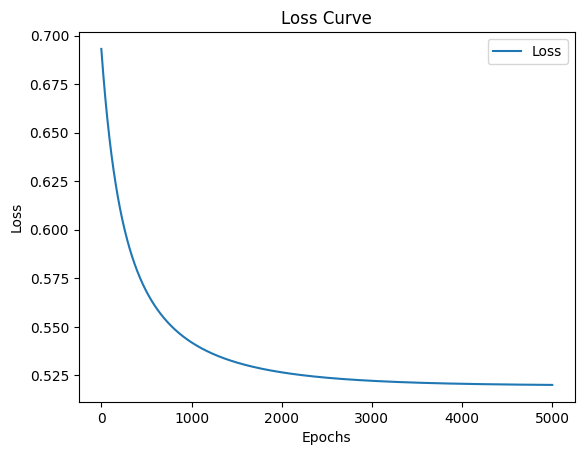

In [23]:
# 使用数据训练逻辑回归模型
learning_rate = 0.01
epochs = 5000

# 将 y_train 和 y_test 转换为 numpy 数组
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# 训练模型
weights, bias, losses = train_logistic_regression(X_train, y_train_np, learning_rate, epochs)

# 计算训练集和测试集的准确率
from sklearn.metrics import accuracy_score

# 训练集准确率
y_train_pred = predict(X_train, weights, bias)
train_accuracy = accuracy_score(y_train_np, y_train_pred)  # 确保与转换后的 y_train_np 一致
print(f"Training Accuracy: {train_accuracy:.4f}")

# 测试集准确率
y_test_pred = predict(X_test, weights, bias)
test_accuracy = accuracy_score(y_test_np, y_test_pred)  # 确保与转换后的 y_test_np 一致
print(f"Test Accuracy: {test_accuracy:.4f}")

# 画出损失下降曲线
import matplotlib.pyplot as plt
plt.plot(range(epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()


C:\Users\Lem17\AppData\Local\Temp\ipykernel_19740\375187918.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, x='Quality', palette=['#1f77b4', '#ff7f0e'])  # 设置两个不同的颜色


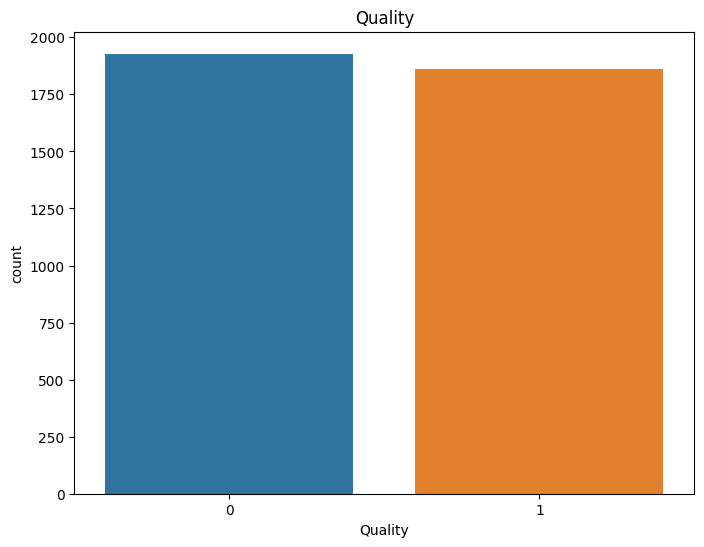

In [16]:
# Plot a countplot to visualize the distribution of the 'Quality' variable
plt.figure(figsize=(8,6))
sns.countplot(data=Data, x='Quality', palette=['#1f77b4', '#ff7f0e'])  # 设置两个不同的颜色
plt.title('Quality')
plt.show()